In [58]:
'''
In this notebook, we experiment anomaly detection on multi-dimensional data using autoencoder of RNN layers
'''
import numpy as np
from scipy.stats import mode
from scipy.stats import norm
from sklearn.svm import SVR
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data definitions

In [2]:
def get_normal_reading(dim, noise_scale):
    w = np.linspace(2.6, 5.8, dim) # frequency
    s = np.linspace(1.2, 9.4, dim)  # phase
    
    t = np.linspace(0, 10.0, 501)
    reading = []
    for i in range(dim):
        signal = np.sin(w[i]*t + s[i])
        noise = np.random.normal(0, noise_scale, len(t))
        reading.append( signal + noise )
    reading = np.array(reading)
    return reading

In [3]:
def get_abnormal_reading(dim, noise_scale, anomaly_magnitude):
    reading = get_normal_reading(dim, noise_scale);
    
    window_size = 13 # anomaly windows size
    window_std = 2 # anomaly standard deviation
    anomaly_dim = 0  # TODO: add anomalies for multiple dimensions
    idx = 401
    
    anomaly = anomaly_magnitude * signal.gaussian(window_size, std=window_std)
    
    reading[anomaly_dim, idx:idx+window_size] += anomaly
    return reading

In [4]:
def get_normal_data(dim, sequence_length, normal_sample_size, noise_scale, **kwargs):
    '''
    x contains the sequences draw from the normal readings. x has the shape of (normal_sample_size, sequence_length, dim)
    y contains the label of if the sequence is an anomaly. In this case, all labels in y are 0.
    '''
    reading = get_normal_reading(dim, noise_scale)
      
    x = []
    y = []
    for _ in range(normal_sample_size):
        i = np.random.randint(0, len(reading[0])-sequence_length-1)
        x.append(reading[:, i:i+sequence_length])
        y.append(0)
        
    x = np.asarray(x, dtype=np.float32)
    # change the shape of x from (normal_sample_size, dim, sequence_length) to (normal_sample_size, sequence_length, dim)
    x = x.transpose((0, 2, 1))
    
    y = np.asarray(y, dtype=np.float32)
    
    return x, y

In [5]:
from scipy import signal
def get_mixed_data(dim, sequence_length, mixed_sample_size, 
                   noise_scale, abnormal_ratio, anomaly_magnitude, **kwargs):
    '''
    x contains the sequences draw from the normal/abnormal readings. 
    x has the shape of (mixed_sample_size, sequence_length, dim)
    
    y contains the label of if the sequence is an anomaly. y=1 means the sequence is abnormal.
    '''
    window_size = 13 # anomaly windows size
    window_std = 2 # anomaly standard deviation
    anomaly_dim = 0 #TODO: add anomalies for multiple dimensions
    
    x, y = get_normal_data(dim, sequence_length, mixed_sample_size, noise_scale)
    for i in range(mixed_sample_size):
        isAnomaly = np.random.choice([0, 1], p=[1-abnormal_ratio, abnormal_ratio])
        if isAnomaly == 1:
            anomaly = anomaly_magnitude * signal.gaussian(window_size, std=window_std)
            idx = np.random.randint(0, sequence_length-window_size)
            x[i, idx:idx+window_size, anomaly_dim] += anomaly
            y[i] = 1
    
    return x, y

## Visualization

In [47]:
def checkLoss(history, logscale=False):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, 'b.-', label='Train MSE')
    plt.plot(epochs, val_loss, 'r.-', label='Validation MSE')
    plt.ylim(1e-3, max(val_loss))
    if (logscale):
        plt.yscale('log')
    plt.legend()
    plt.show()

def checkPrediction(x_train, x_test, y_test, pred_train, pred_test):
    x_normal = x_test[y_test==0]
    x_abnormal = x_test[y_test==1]
    
    pred_normal = pred_test[y_test==0]
    pred_abnormal = pred_test[y_test==1]
    
    idx = 45
    abnormal_dim = 0
    normal_dim = 1
    n_pics = 5
    n_category = 3
    plt.figure(figsize=(12, 6))
    for i in range(n_pics):
        # abnormal dim in training data
        ax = plt.subplot(n_category, n_pics, 0*n_pics+i+1)
        plt.plot(x_train[idx + i, :, abnormal_dim], 'b.')
        plt.plot(pred_train[idx + i, :, abnormal_dim], 'r-')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # abnormal dim in normal test data
        ax = plt.subplot(n_category, n_pics, 1*n_pics+i+1)
        plt.plot(x_normal[idx + i, :, abnormal_dim], 'b.')
        plt.plot(pred_normal[idx + i, :, abnormal_dim], 'r-')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # abnormal dim in abnormal test data
        ax = plt.subplot(n_category, n_pics, 2*n_pics+i+1)
        plt.plot(x_abnormal[idx + i, :, abnormal_dim], 'b.')
        plt.plot(pred_abnormal[idx + i, :, abnormal_dim], 'r-')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    

def checkError(x_train, x_test, y_test, pred_train, pred_test, dim):
    x_normal = x_test[y_test==0]
    x_abnormal = x_test[y_test==1]
    
    pred_normal = pred_test[y_test==0]
    pred_abnormal = pred_test[y_test==1]
    
    error_train = np.average((pred_train - x_train)**2, axis=1)
    error_normal = np.average((pred_normal - x_normal)**2, axis=1)
    error_abnormal = np.average((pred_abnormal - x_abnormal)**2, axis=1)        
    
    threshold = np.zeros(dim)
    for i in range(dim):
        lower, _ = mode(error_normal[:,i])
        upper, _ = mode(error_abnormal[:,i])
        threshold[i] = 0.5*(lower + upper)
   
    nBins = 30
    n = int(np.ceil(np.sqrt(dim)))
    plt.figure(figsize=(12, 9))
    for i in range(dim):
        ax = plt.subplot(n, n, i+1)
        plt.title("Encoding error on dimension " + str(i))
        plt.hist(error_train[:, i],    bins=nBins, density=True, fc=(0, 1, 0, 0.5), label="Train")
        plt.hist(error_normal[:, i],   bins=nBins, density=True, fc=(0, 0, 1, 0.5), label="Normal in test")
        plt.hist(error_abnormal[:, i], bins=nBins, density=True, fc=(1, 0, 0, 0.5), label='Abnormal in test')
        plt.axvline(x=threshold[i], linestyle='dashed')
        plt.legend()
    plt.show()
    
    return threshold
    

## Data generation

In [7]:
params = {'dim':2, 'sequence_length':37, 'noise_scale':0.03, 
          'normal_sample_size':8192, 'mixed_sample_size':2048, 'abnormal_ratio':0.5, 'anomaly_magnitude':0.8}

x_train, y_train = get_normal_data(**params)
x_test, y_test = get_mixed_data(**params)

## Data visualization

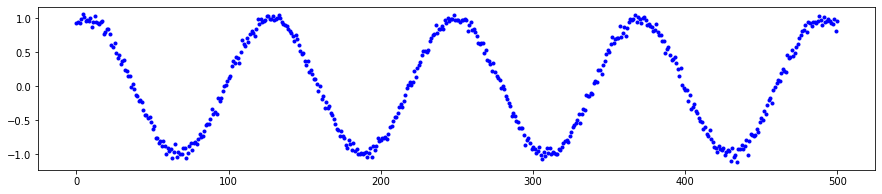

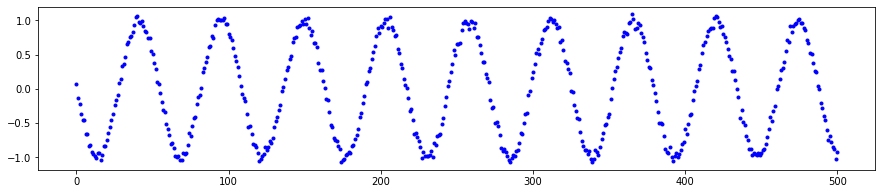

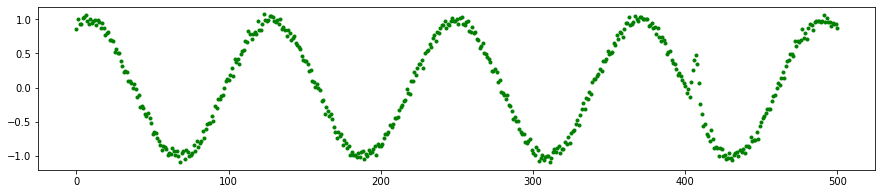

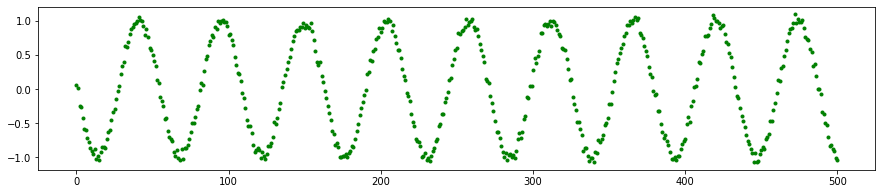

In [8]:
normal_data_dim = 2
normal_reading = get_normal_reading(dim=normal_data_dim, noise_scale=0.05)

for i in range(normal_data_dim):
    plt.figure(figsize=(15,3))
    plt.plot(normal_reading[i], 'b.')

abnormal_reading = get_abnormal_reading(dim=2, noise_scale=0.05, anomaly_magnitude=0.8)
plt.figure(figsize=(15,3))
plt.plot(abnormal_reading[0], 'g.')
plt.figure(figsize=(15,3))
plt.plot(abnormal_reading[1], 'g.')

## FC autoencoder

In [9]:
from keras import layers
from keras import Model

# Autoencoder by FC layers
def get_model_fc(dim, sequence_length):
    input_sequence = layers.Input(shape=(dim*sequence_length, ), name='input_sequence')
    x = layers.Dense(units=128, activation='relu')(input_sequence)
    # x = layers.Dropout(0.1)(x)
    decoded = layers.Dense(units=dim*sequence_length, name='output_sequence')(x)
    
    autoencoder = Model(input_sequence, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

Using TensorFlow backend.


In [10]:
x_train_flatten = np.reshape(x_train, (x_train.shape[0], np.prod(x_train.shape[1:])))
x_test_flatten = np.reshape(x_test, (x_test.shape[0], np.prod(x_test.shape[1:])))

model_fc = get_model_fc(dim=params['dim'], sequence_length=params['sequence_length'])
history_fc = model_fc.fit(x_train_flatten, x_train_flatten, batch_size=64, epochs=20, 
          validation_data=(x_test_flatten[y_test==0], x_test_flatten[y_test==0]))








Train on 8192 samples, validate on 1019 samples
Epoch 1/20





8192/8192 [==============================] - 0s 59us/step - loss: 0.0723 - val_loss: 0.0038
Epoch 2/20
8192/8192 [==============================] - 0s 21us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 3/20
8192/8192 [==============================] - 0s 19us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/20
8192/8192 [==============================] - 0s 19us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/20
8192/8192 [==============================] - 0s 19us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/20
8192/8192 [==============================] - 0s 21us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/20
8192/8192 [==============================] - 0s 21us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/20
8192/8192 [==============================] - 0s 21us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/20
8192/8192 [==============================] - 0s 20us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/20
8

In [11]:
model_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_sequence (InputLayer)  (None, 74)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               9600      
_________________________________________________________________
output_sequence (Dense)      (None, 74)                9546      
Total params: 19,146
Trainable params: 19,146
Non-trainable params: 0
_________________________________________________________________


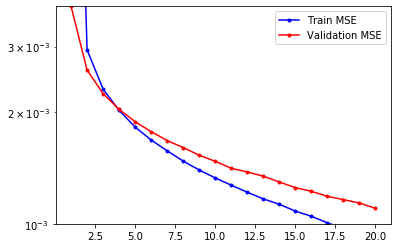

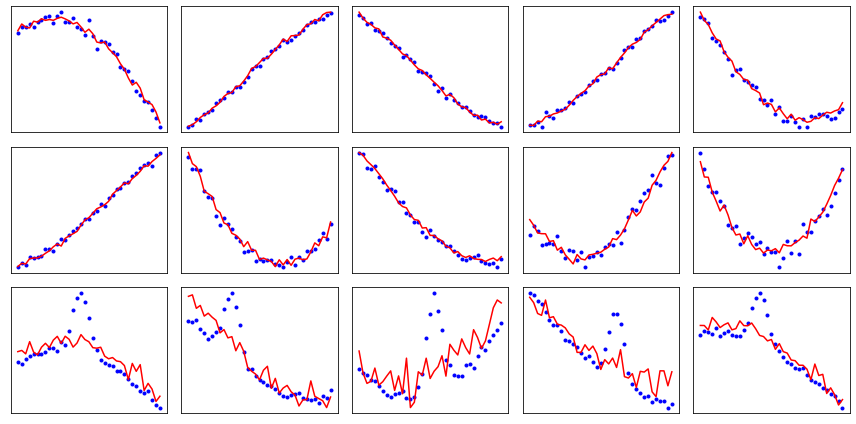

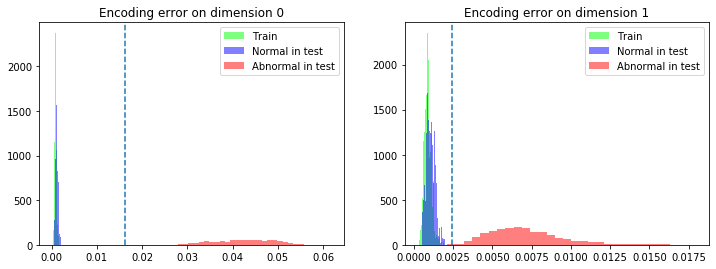

In [48]:
pred_train_flatten = model_fc.predict(x_train_flatten)
pred_test_flatten = model_fc.predict(x_test_flatten)

pred_train_fc = np.reshape(pred_train_flatten, (pred_train_flatten.shape[0], params['sequence_length'], params['dim']))
pred_test_fc = np.reshape(pred_test_flatten, (pred_test_flatten.shape[0], params['sequence_length'], params['dim']))

checkLoss(history_fc, logscale=True)
checkPrediction(x_train, x_test, y_test, pred_train_fc, pred_test_fc)
anomaly_threshold_fc=checkError(x_train, x_test, y_test, pred_train_fc, pred_test_fc, dim=params['dim'])

In [13]:
rec_err = np.zeros((params['dim'], x_test.shape[0]))
for dim in range(params['dim']):
    rec_err[dim,:] = np.mean((pred_test_fc[:,:,dim] - x_test[:,:,dim])**2, axis=1)
#end for

fc_anomaly = np.zeros((params['dim'], x_test.shape[0]))
for dim in range(params['dim']):
    for idx in range(x_test.shape[0]):
        if (rec_err[dim,idx] >= anomaly_threshold_fc[dim]):
            fc_anomaly[dim,idx] = 1
        else:
            fc_anomaly[dim,idx] = 0
    #end for
#end for

In [14]:
fc_anomaly_alldim = (np.sum(fc_anomaly, axis=0) > fc_anomaly.shape[0]/2.0).astype(int)

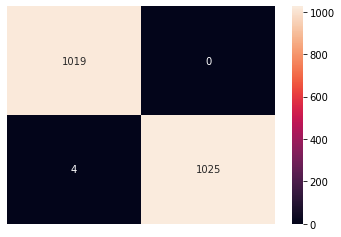

In [15]:
cmt_fc = confusion_matrix(y_test, fc_anomaly_alldim)
ax = sns.heatmap(cmt_fc, annot=True, fmt='d',  xticklabels=False, yticklabels=False)

In [16]:
acc_fc = np.trace(cmt_fc)/np.sum(np.sum(cmt_fc))
print("accuracy: ", acc_fc)

accuracy:  0.998046875


## RNN autoencoder

In [17]:
from keras import layers
from keras.models import Model

# Autoencoder by RNN layer
def get_model_rnn(dim, sequence_length):
    input_sequence = layers.Input(shape=(sequence_length, dim))
    x = layers.LSTM(units=128, activation='relu', return_sequences=False)(input_sequence)
    x = layers.RepeatVector(sequence_length)(x)
    x = layers.LSTM(units=128, activation='relu', return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(dim))(x)
    
    autoencoder = Model(input_sequence, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder


# experimental model architecture
def get_model_temp(dim, sequence_length):
    input_sequence = layers.Input(shape=(sequence_length, dim))
    x = layers.GRU(units=128, activation='relu', return_sequences=False)(input_sequence)
    x = layers.RepeatVector(sequence_length)(x)
    x = layers.GRU(units=128, activation='relu', return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(dim))(x)
    
    autoencoder = Model(input_sequence, x)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [18]:
model_rnn = get_model_rnn(dim=params['dim'], sequence_length=params['sequence_length'])
history_rnn = model_rnn.fit(x_train, x_train, batch_size=64, epochs=5, validation_data=(x_test[y_test==0], x_test[y_test==0]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8192 samples, validate on 1019 samples
Epoch 1/5
8192/8192 [==============================] - 13s 2ms/step - loss: 0.1847 - val_loss: 0.0235
Epoch 2/5
8192/8192 [==============================] - 11s 1ms/step - loss: 0.0107 - val_loss: 0.0039
Epoch 3/5
8192/8192 [==============================] - 11s 1ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 4/5
8192/8192 [==============================] - 11s 1ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 5/5
8192/8192 [==============================] - 11s 1ms/step - loss: 0.0018 - val_loss: 0.0013


In [19]:
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 37, 2)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               67072     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 37, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 37, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 37, 2)             258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
_________________________________________________________________


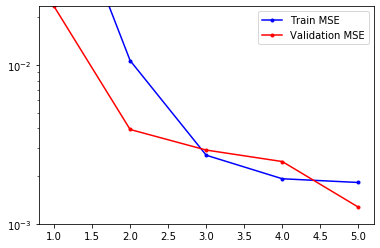

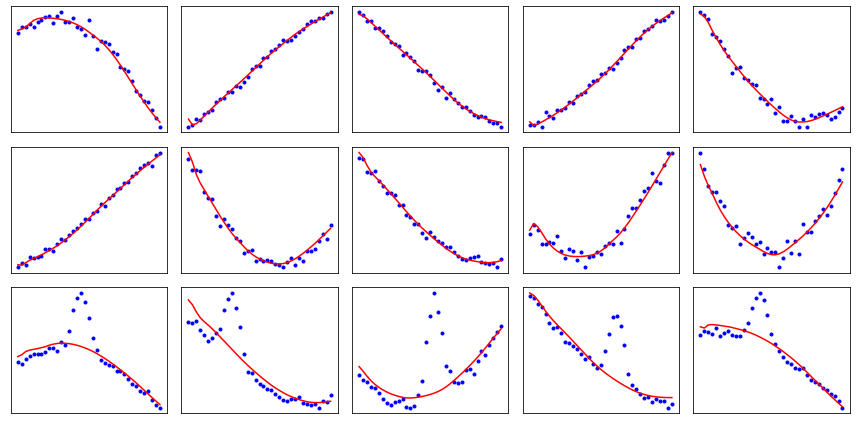

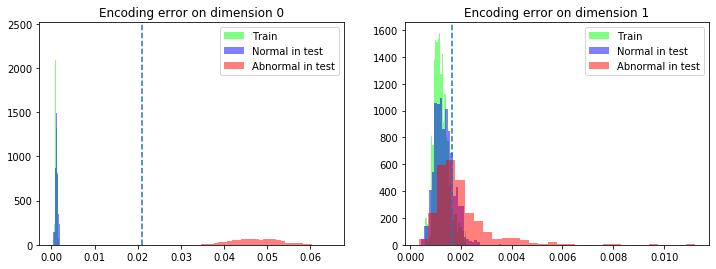

In [50]:
pred_train_rnn = model_rnn.predict(x_train)
pred_test_rnn = model_rnn.predict(x_test)

checkLoss(history_rnn, logscale=True)
checkPrediction(x_train, x_test, y_test, pred_train_rnn, pred_test_rnn)
anomaly_threshold_rnn=checkError(x_train, x_test, y_test, pred_train_rnn, pred_test_rnn, dim=params['dim'])

In [22]:
rec_err_rnn = np.zeros((params['dim'], x_test.shape[0]))
for dim in range(params['dim']):
    rec_err_rnn[dim,:] = np.mean((pred_test_rnn[:,:,dim] - x_test[:,:,dim])**2, axis=1)
#end for

rnn_anomaly = np.zeros((params['dim'], x_test.shape[0]))
for dim in range(params['dim']):
    for idx in range(x_test.shape[0]):
        if (rec_err_rnn[dim,idx] >= anomaly_threshold_rnn[dim]):
            rnn_anomaly[dim,idx] = 1
        else:
            rnn_anomaly[dim,idx] = 0
    #end for
#end for

In [23]:
rnn_anomaly_alldim = (np.sum(rnn_anomaly, axis=0) > rnn_anomaly.shape[0]/2).astype(int)

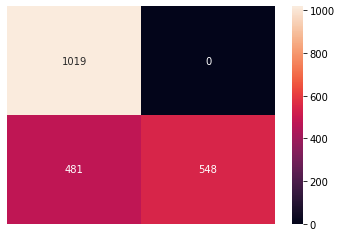

In [24]:
cmt_rnn = confusion_matrix(y_test, rnn_anomaly_alldim)
ax = sns.heatmap(cmt_rnn, annot=True, fmt='d',  xticklabels=False, yticklabels=False)

In [25]:
acc_rnn = np.trace(cmt_rnn)/np.sum(np.sum(cmt_rnn))
print("accuracy: ", acc_rnn)

accuracy:  0.76513671875


## LSTM-VAE Anomaly Detector

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

In [27]:
def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [28]:
#training params
batch_size = 256
num_epochs = 16 

#model params
timesteps = x_train.shape[1]
input_dim = x_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [29]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [ ]:
#VAE architecture

#encoder
x = Input(shape=(timesteps, input_dim,))
h = LSTM(intermediate_dim)(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_mean = LSTM(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

#re-encoder
h2 = LSTM(intermediate_dim)(x_decoded_mean)

z_mean2 = Dense(1)(h2)
z_log_sigma2 = Dense(1)(h2)

In [ ]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    #def vae_loss(self, x, x_decoded_mean):
    #    xent_loss = input_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    #    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    #    return K.mean(xent_loss + kl_loss)
    
    def vae_loss(self, x, x_decoded_mean, z_mean2, z_log_sigma2):
        xent_loss = K.mean(metrics.mse(x, x_decoded_mean))
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        z_loss = K.mean(metrics.mse(z_mean, z_mean2) + metrics.mse(K.exp(z_log_sigma), K.exp(z_log_sigma2)))
        loss = xent_loss + kl_loss + z_loss
        return loss

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        z_mean2 = inputs[2]
        z_log_sigma2 = inputs[3]
        loss = self.vae_loss(x, x_decoded_mean, z_mean2, z_log_sigma2)
        self.add_loss(loss, inputs=inputs)
        return x

In [ ]:
y = CustomVariationalLayer()([x, x_decoded_mean, z_mean2, z_log_sigma2])
vae_zsp = Model(x, z)
vae_lat = Model(x, [z_mean2, z_log_sigma2])
vae = Model(x, y)

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()

In [ ]:
#define callbacks
file_name = './data/lstm-vae-weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [ ]:
print("training vae model...")
hist_vae = vae.fit(x=x_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test, None), verbose=2)

In [ ]:
pred_train_vae = vae.predict(x_train)
pred_test_vae = vae.predict(x_test)

checkLoss(hist_vae, logscale=False)
checkPrediction(x_train, x_test, y_test, pred_train_vae, pred_test_vae)
checkError(x_train, x_test, y_test, pred_train_vae, pred_test_vae, dim=params['dim'])

In [ ]:
#anomaly_score = []
#num_batches = int(x_test.shape[0] / batch_size)
#for batch_idx in range(num_batches):
#    test_batch = x_test[batch_idx * batch_size : (batch_idx+1) * batch_size,:]
#    anomaly_score.append(vae.evaluate(test_batch))

In [ ]:
#Training Overview
#1. For training batch in x_train
#2.   compute encoder output (z)
#3.   compute associated mu_x and sigma_x
#4.   compute score s: -log N(x_batch; mu_x, sigma_x)
#5.   add z and s to Z and S
#6. fit SVR to learn the threshold

In [ ]:
latent_state_tr, anomaly_score_tr = [], []
num_batches = int(x_train.shape[0] / batch_size)
for batch_idx in range(num_batches):
    train_batch = x_train[batch_idx * batch_size : (batch_idx+1) * batch_size,:]
    z_tr = vae_zsp.predict(train_batch).tolist()
    z_mean_tr, z_log_sigma_tr = vae_lat.predict(train_batch)
    
    score_list_tr=[]
    for ii in range(train_batch.shape[0]):
        score_tr = -np.sum(norm.logpdf(x=train_batch[ii,:,:], loc=z_mean_tr[ii], scale=np.exp(z_log_sigma_tr[ii])))
        score_list_tr.append(score_tr)
        
    latent_state_tr.extend(z_tr)
    anomaly_score_tr.extend(score_list_tr)
#end for

In [ ]:
clf_svr = SVR(C=1.0, epsilon=0.2)
clf_svr.fit(X=np.array(latent_state_tr), y=np.array(anomaly_score_tr))

In [ ]:
#Testing Overview
#1. For validation batch in x_test
#2.   compute encoder output (z)
#3.   compute associated mu_x and sigma_x
#4.   compute score s: -log N(x_batch; mu_x, sigma_x)
#5.   if score > svr_treshold + c
#         return anomaly

In [ ]:
score_list, anomaly_threshold = [], []
num_batches = int(x_test.shape[0] / batch_size)
for batch_idx in range(num_batches):
    test_batch = x_test[batch_idx * batch_size : (batch_idx+1) * batch_size,:]
    z_tb = vae_zsp.predict(test_batch).tolist()
    z_mean_tb, z_log_sigma_tb = vae_lat.predict(test_batch)
    
    score_list_tb=[]
    for ii in range(test_batch.shape[0]):
        score_tb = -np.sum(norm.logpdf(x=test_batch[ii,:,:], loc=z_mean_tb[ii], scale=np.exp(z_log_sigma_tb[ii])))
        score_list_tb.append(score_tb)
    
    threshold_tb = clf_svr.predict(z_tb).tolist()
    
    score_list.extend(score_list_tb)
    anomaly_threshold.extend(threshold_tb)
#end for

In [ ]:
anomaly_threshold

In [ ]:
lstm_vae_anomaly = []
for idx in range(len(score_list)):
    if (score_list[idx] >= anomaly_threshold[idx]):
        lstm_vae_anomaly.append(1)
    else:
        lstm_vae_anomaly.append(0)
#end for

In [ ]:
cmt = confusion_matrix(y_test, lstm_vae_anomaly)
ax = sns.heatmap(cmt, annot=True, fmt='d',  xticklabels=False, yticklabels=False)

In [ ]:
acc = np.trace(cmt)/np.sum(np.sum(cmt))
print("accuracy: ", acc)

## LSTM-VAE Anomaly Detector with One-Class SVM

In [32]:
#training params
batch_size = 256
num_epochs = 16 

#model params
timesteps = x_train.shape[1]
input_dim = x_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [33]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [34]:
#VAE architecture

#encoder
x = Input(shape=(timesteps, input_dim,))
h = LSTM(intermediate_dim)(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_mean = LSTM(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

In [36]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = K.mean(metrics.mse(x, x_decoded_mean))
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))        
        loss = xent_loss + kl_loss
        return loss

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        return x

In [43]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae_z = Model(x, z)
vae_lstm_svm = Model(x, y)

In [44]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae_lstm_svm.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae_lstm_svm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 37, 2)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 16)           1216        input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            34          lstm_3[0][0]                     
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            34          lstm_3[0][0]                     
__________________________________________________________________________________________________
lambda_1 (

In [40]:
#define callbacks
file_name = './data/lstm-vae-svm-weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [45]:
print("training vae model...")
hist_vae_lstm_svm = vae_lstm_svm.fit(x=x_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test, None), verbose=2)

training vae model...
Train on 8192 samples, validate on 2048 samples
Epoch 1/16
 - 6s - loss: 0.5065 - val_loss: 0.5147

Epoch 00001: loss improved from inf to 0.50653, saving model to ./data/lstm-vae-svm-weights-checkpoint.hdf5
Epoch 2/16
 - 2s - loss: 0.4944 - val_loss: 0.5129

Epoch 00002: loss improved from 0.50653 to 0.49437, saving model to ./data/lstm-vae-svm-weights-checkpoint.hdf5
Epoch 3/16
 - 2s - loss: 0.4932 - val_loss: 0.5128

Epoch 00003: loss improved from 0.49437 to 0.49317, saving model to ./data/lstm-vae-svm-weights-checkpoint.hdf5
Epoch 4/16
 - 2s - loss: 0.4930 - val_loss: 0.5139

Epoch 00004: loss improved from 0.49317 to 0.49302, saving model to ./data/lstm-vae-svm-weights-checkpoint.hdf5
Epoch 5/16
 - 2s - loss: 0.4928 - val_loss: 0.5129

Epoch 00005: loss improved from 0.49302 to 0.49277, saving model to ./data/lstm-vae-svm-weights-checkpoint.hdf5
Epoch 6/16
 - 2s - loss: 0.4928 - val_loss: 0.5113

Epoch 00006: loss did not improve from 0.49277
Epoch 7/16
 - 2

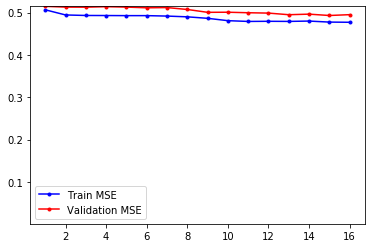

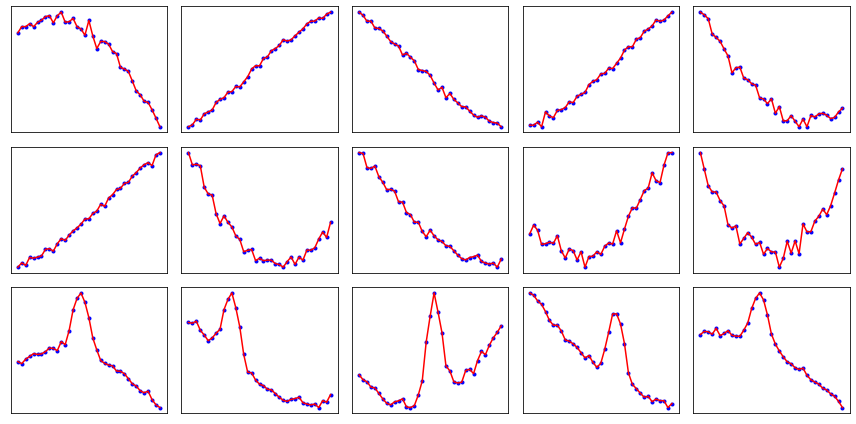

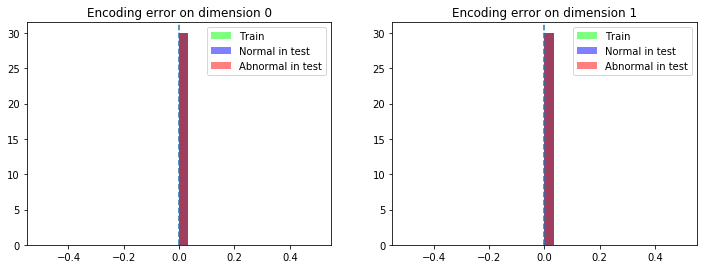

array([0., 0.])

In [52]:
pred_train_vae_lstm_svm = vae_lstm_svm.predict(x_train)
pred_test_vae_lstm_svm = vae_lstm_svm.predict(x_test)

checkLoss(hist_vae_lstm_svm, logscale=False)
checkPrediction(x_train, x_test, y_test, pred_train_vae_lstm_svm, pred_test_vae_lstm_svm)
checkError(x_train, x_test, y_test, pred_train_vae_lstm_svm, pred_test_vae_lstm_svm, dim=params['dim'])

In [53]:
#Training Overview
#1. For training batch in x_train
#2.   compute encoder output (z)
#5.   add z to Z
#6. fit 1-class SVM to Z

In [54]:
latent_state_train = []
num_batches = int(x_train.shape[0] / batch_size)
for batch_idx in range(num_batches):
    train_batch = x_train[batch_idx * batch_size : (batch_idx+1) * batch_size,:]
    z_train = vae_z.predict(train_batch).tolist()
    latent_state_train.extend(z_train)
#end for

In [59]:
clf_svm1 = OneClassSVM(gamma='auto').fit(latent_state_train)

In [61]:
#Testing Overview
#1. For validation batch in x_test
#2.   compute encoder output (z)
#3.   compute outliers

In [62]:
latent_state_test = []
num_batches = int(x_test.shape[0] / batch_size)
for batch_idx in range(num_batches):
    test_batch = x_test[batch_idx * batch_size : (batch_idx+1) * batch_size,:]
    z_test = vae_z.predict(test_batch).tolist()
    latent_state_test.extend(z_test)
#end for

In [66]:
lstm_vae_svm_anomaly = clf_svm1.predict(latent_state_test)

In [78]:
lstm_vae_svm_anomaly_mapped = np.array(list(map(lambda x: 1 if x == -1 else 0, lstm_vae_svm_anomaly)))

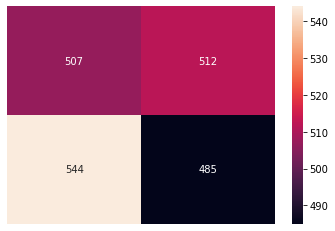

In [79]:
cmt_lstm_vae_svm = confusion_matrix(y_test, lstm_vae_svm_anomaly_mapped)
ax = sns.heatmap(cmt_lstm_vae_svm, annot=True, fmt='d',  xticklabels=False, yticklabels=False)

In [80]:
acc = np.trace(cmt_lstm_vae_svm)/np.sum(np.sum(cmt_lstm_vae_svm))
print("accuracy: ", acc)

accuracy:  0.484375


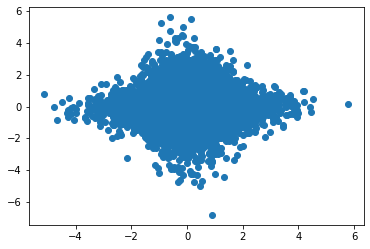

In [94]:
plt.scatter(np.array(latent_state_train)[:,0], np.array(latent_state_train)[:,1])

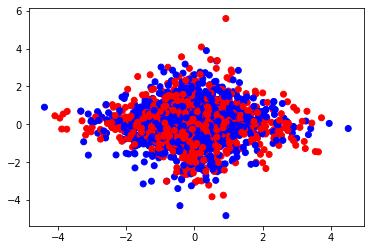

In [102]:
clr1 = map(lambda x: 'red' if x==1 else 'blue', y_test)
clr2 = map(lambda x: 'red' if x==1 else 'blue', lstm_vae_svm_anomaly_mapped)
plt.scatter(np.array(latent_state_test)[:,0], np.array(latent_state_test)[:,1], color=list(clr1))

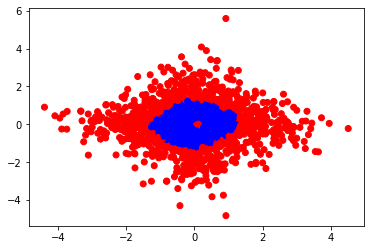

In [103]:
clr1 = map(lambda x: 'red' if x==1 else 'blue', y_test)
clr2 = map(lambda x: 'red' if x==1 else 'blue', lstm_vae_svm_anomaly_mapped)
plt.scatter(np.array(latent_state_test)[:,0], np.array(latent_state_test)[:,1], color=list(clr2))